## FireEye Health Insurance 2015 Analysis  
## Family Plans  
### Assumptions:  
* In-network procedures 
* All medical bills are paid pre-tax (via either HSAs or FSAs).

### Plan Details

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

class Plan:
    def __init__(self): pass

# Plan 1 = Cigna HDHP/HSA
p1 = Plan()    
p1.family_deductible = 4000.00     # Same deductible for both family and individual
p1.individual_deductible = 4000.00
p1.family_oopmax = 6000.00      # Same out-of-pocket max for family and individual
p1.individual_oopmax = 6000.00
p1.premium_monthly = 46*2 # $46 * 2 times/month
p1.hsa_contribution = 2400.00
p1.coinsurance_rate = 0.1

# Plan 2 = Cigna PPO $1000
p2 = Plan()
p2.family_deductible = 2000.00
p2.individual_deductible = 1000.00
p2.family_oopmax = 8000.00
p2.individual_oopmax = 4000.00
p2.premium_monthly = 46*2 # $46 * 2 times/month
p2.hsa_contribution = 0.0
p2.coinsurance_rate = 0.2

# Plan 3 = Cigna PPO $500
p3 = Plan()
p3.family_deductible = 1000.00
p3.individual_deductible = 500.00
p3.family_oopmax = 7000.00
p3.individual_oopmax = 3500.00
p3.premium_monthly = 103*2 # $103 * 2 times/month
p3.hsa_contribution = 0.0
p3.coinsurance_rate = 0.1

### Helper functions

In [2]:
# For the purposes of this estimation, we are assuming the deductible
# is always larger than the HSA contribution amount
def apply_deductible_and_hsa(cost, deductible, hsa):
    cost_to_you = 0
    cost_remaining = 0
    
    # Apply HSA
    deductible_minus_hsa = deductible - hsa
    
    if cost <= hsa:
        cost_to_you = 0
        cost_remaining = 0
    elif cost <= deductible:
        cost_to_you = cost - hsa
        cost_remaining = 0
    elif cost > deductible:
        cost_to_you = deductible_minus_hsa
        cost_remaining = cost - deductible

    return (cost_to_you, cost_remaining)

def apply_coinsurance(cost, coinsurance_rate):
    return cost * coinsurance_rate

def apply_oopmax(cost, oopmax):
    if cost >= oopmax:
        return oopmax
    else:
        return cost
    
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    

### Plan cost functions

In [3]:
def individual_cost(plan, gross_cost):
    (cost_to_you, cost_remaining) = apply_deductible_and_hsa(gross_cost, 
                                    plan.individual_deductible, 
                                    plan.hsa_contribution)
    cost_to_you += apply_coinsurance(cost_remaining, plan.coinsurance_rate)
    cost_to_you = apply_oopmax(cost_to_you, plan.individual_oopmax)
    
    # Apply yearly premiums - note that the out-of-pocket max doesn't include
    # the premiums; thus, we apply them after applying out-of-pocket max.
    cost_to_you += (plan.premium_monthly * 12)
    return cost_to_you
    
    
def family_cost(plan, gross_cost):
    (cost_to_you, cost_remaining) = apply_deductible_and_hsa(gross_cost, 
                                    plan.family_deductible, 
                                    plan.hsa_contribution)
    cost_to_you += apply_coinsurance(cost_remaining, plan.coinsurance_rate)
    cost_to_you = apply_oopmax(cost_to_you, plan.family_oopmax)
    
    # Apply yearly premiums - note that the out-of-pocket max doesn't include
    # the premiums; thus, we apply them after applying out-of-pocket max.
    cost_to_you += (plan.premium_monthly * 12)
    return cost_to_you


### Sanity Tests

#### Zero costs

In [4]:
# Should be the monthly premium times 12 (to make up the yearly premium).
family_cost(p1, 0)

1104.0

In [5]:
p1.premium_monthly * 12.0

1104.0

In [6]:
family_cost(p2, 0)

1104.0

In [7]:
p2.premium_monthly * 12.0

1104.0

In [8]:
family_cost(p3, 0)

2472.0

In [9]:
p3.premium_monthly * 12.0

2472.0

#### Cost less than HSA

In [10]:
# Should be monthly premium times 12
family_cost(p1, 2400) == p1.premium_monthly * 12

True

#### Cost greater than HSA and deductible

In [11]:
(p1.premium_monthly * 12) + \
(p1.family_deductible - p1.hsa_contribution) + \
(6000 - p1.family_deductible) * p1.coinsurance_rate

2904.0

In [12]:
family_cost(p1, 6000)

2904.0

### Family Cost graph

Cost taking into account the whole family (more than 1 person) accruing medical costs.

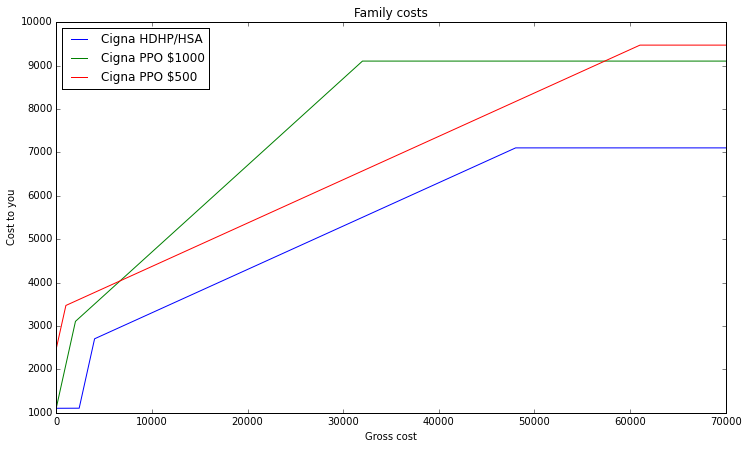

In [13]:
# Calculate costs
gross_costs = range(0, 70000)
p1_costs = [family_cost(p1, cost) for cost in gross_costs]
p2_costs = [family_cost(p2, cost) for cost in gross_costs]
p3_costs = [family_cost(p3, cost) for cost in gross_costs]

# Do graph
setup_graph(title='Family costs', x_label='Gross cost', y_label='Cost to you', fig_size=(12,7))
ax = plt.subplot(1,1,1)
p1_graph, = ax.plot(gross_costs, p1_costs, label="Cigna HDHP/HSA")
p2_graph, = ax.plot(gross_costs, p2_costs, label="Cigna PPO $1000")
p3_graph, = ax.plot(gross_costs, p3_costs, label="Cigna PPO $500")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')
plt.show()

### Individual Cost

Cost taking into account 1 person accruing medical costs.

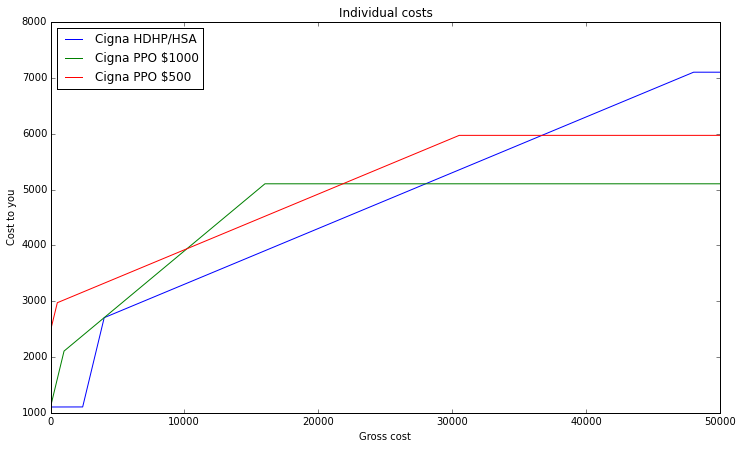

In [15]:
# Calculate costs
gross_costs = range(0, 50000)
p1_costs = [individual_cost(p1, cost) for cost in gross_costs]
p2_costs = [individual_cost(p2, cost) for cost in gross_costs]
p3_costs = [individual_cost(p3, cost) for cost in gross_costs]

# Do graph
setup_graph(title='Individual costs', x_label='Gross cost', y_label='Cost to you', fig_size=(12,7))
ax = plt.subplot(1,1,1)
p1_graph, = ax.plot(gross_costs, p1_costs, label="Cigna HDHP/HSA")
p2_graph, = ax.plot(gross_costs, p2_costs, label="Cigna PPO $1000")
p3_graph, = ax.plot(gross_costs, p3_costs, label="Cigna PPO $500")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')
plt.show()

# Conclusion

For family coverage, you should probably buy the High-Deductible Health Plan!